# Fold exponential spectra through the MagEIS isotropic response functions 

This notebook explores the Bayes appoach to estimate a given exponential spectra that is folded through the MagEIS LOW's isotropic response functions (energy-dependent geometric factors)

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [2]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP MagEIS LOW.
E = R.E*1000 # Energy channel array in keV.
n_ch = 15

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch)
for i in range(n_ch):
    true_lambda[i] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now I code in my own trapezium integrator and check against the above values (to make it compatable with pymc3).

In [3]:
true_lambda2 = np.nan*np.zeros(n_ch)
#dE = E[1:] - E[:-1]
for i in range(n_ch):
    lamE = spectra(E, J0t, E0t)*R.response(i)
    # convert all of these basic functions to pymc3.math functions
    true_lambda2[i] = 0.5*np.sum((lamE[1:]+lamE[:-1])*(E[1:] - E[:-1]))

In [4]:
# The difference between scipy's trapz and my trapz
true_lambda-true_lambda2

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])

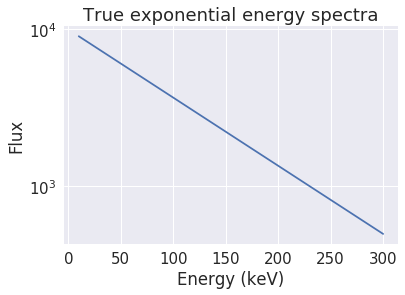

In [5]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

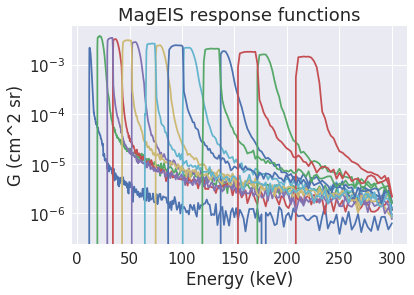

In [6]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

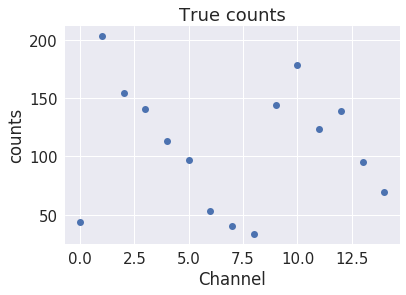

In [7]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [8]:
np.random.seed(123)
#c_obs = [262, 262, 240, 195, 169, 136, 110, 97, 68]
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

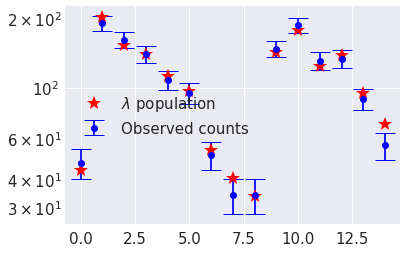

In [9]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(n_ch), true_lambda, 'r*', ms=15, label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

In [10]:
m = pm.Model()

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    for i in range(len(c_obs)):
        f = JJ*R.response(i)
        lams[i] = pm.Deterministic(
            'lam{}'.format(i), 0.5*pm.math.sum((f[1:]+f[:-1])*(E[1:] - E[:-1])))
    return lams

with m:
    # Prior stocastic variables
    J0 = pm.Uniform('J0', lower=1, upper=5E7)
    E0 = pm.Uniform('E0', lower=1/1000, upper=300)
    
    # Define an exponential spectra
    J = J0*pm.math.exp(-E/E0)
    
    lams = lam(J)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [E0_interval__, J0_interval__]
100%|██████████| 10500/10500.0 [01:39<00:00, 105.79it/s]
The acceptance probability does not match the target. It is 0.950497646781, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.961612738181, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.953149199452, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


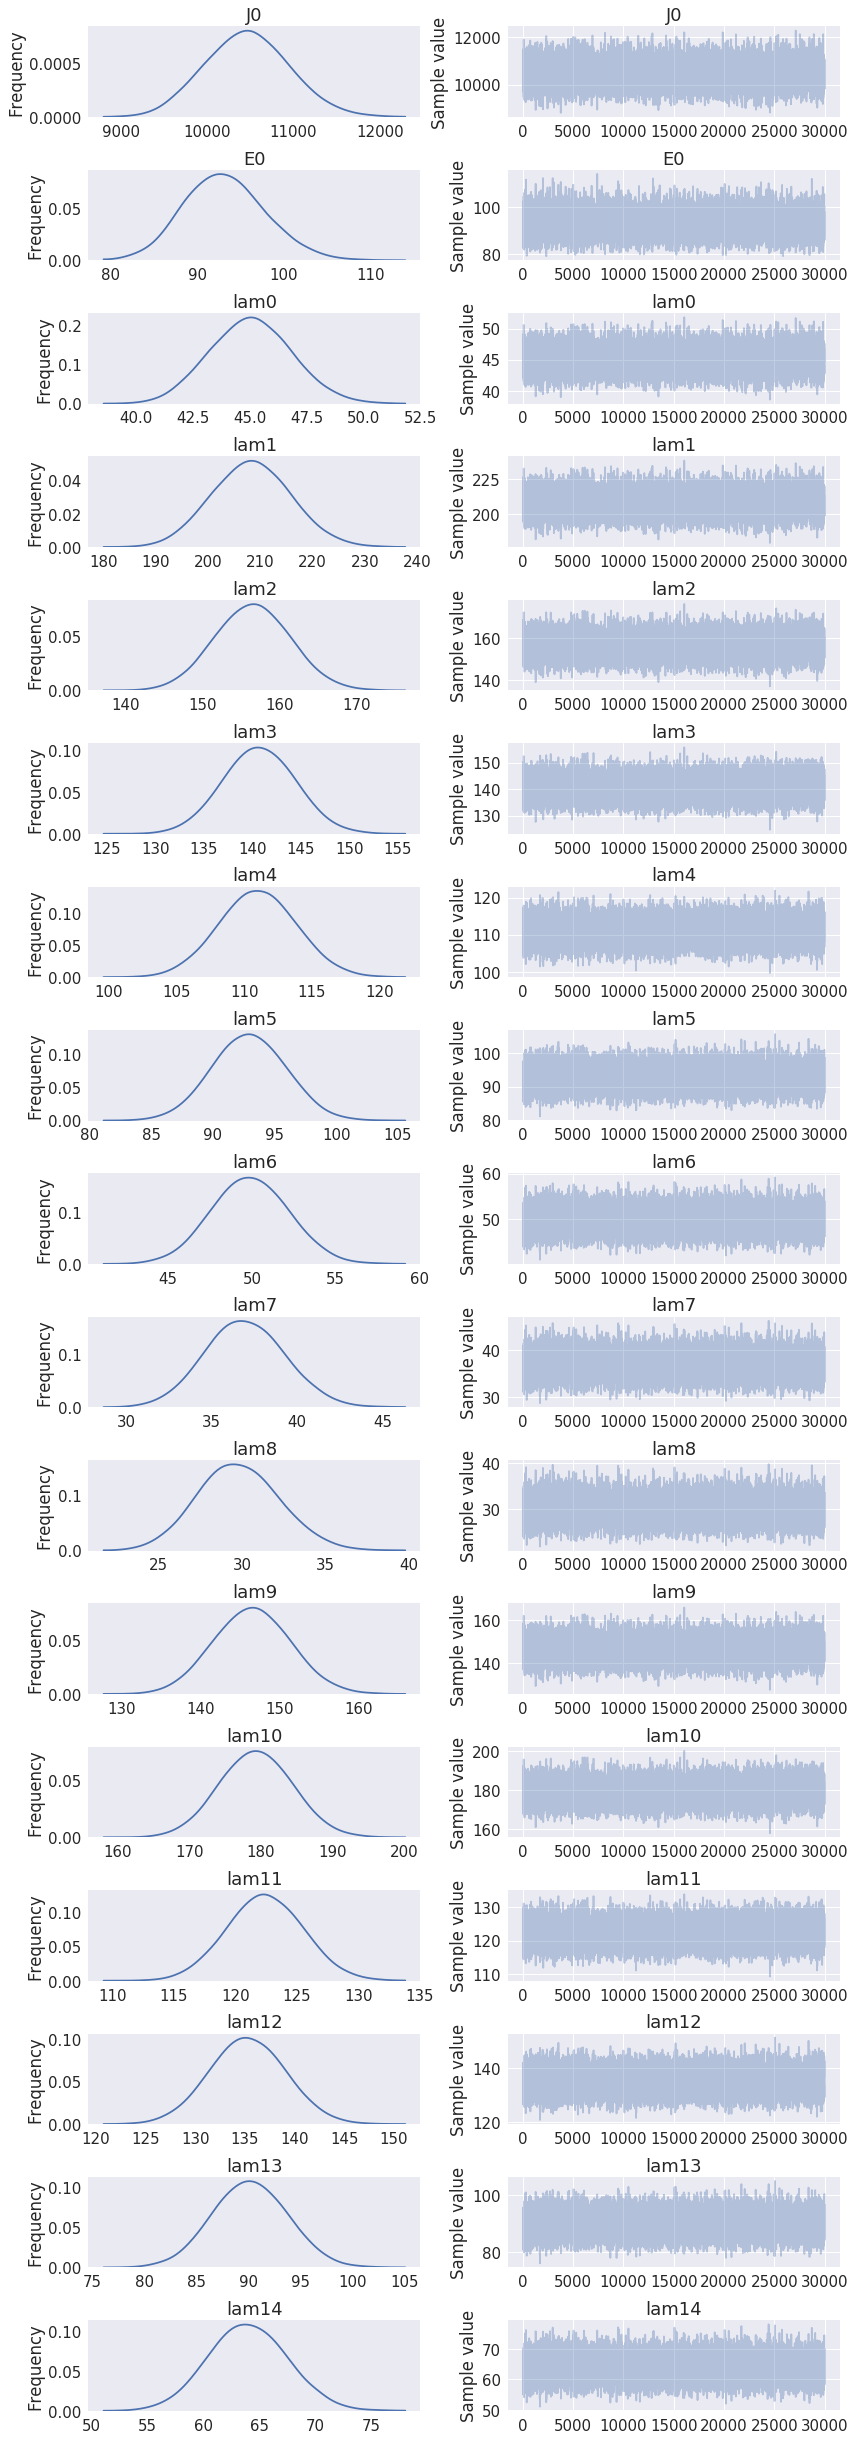

In [11]:
pm.traceplot(trace, combined=True);

In [12]:
pm.summary(trace)

mean          sd  mc_error      hpd_2.5      hpd_97.5  \
J0     10459.366393  484.905245  4.751845  9512.673808  11401.535443   
E0        93.117974    4.660432  0.048347    84.463702    102.692075   
lam0      45.032856    1.782045  0.016930    41.630306     48.566710   
lam1     208.211891    7.485077  0.069127   193.283006    222.478620   
lam2     156.401635    4.830142  0.041546   147.043628    165.895857   
lam3     140.648738    3.690623  0.026986   133.434935    147.850627   
lam4     110.956789    2.821812  0.017436   105.355401    116.394914   
lam5      92.892506    2.942969  0.021334    87.239466     98.674087   
lam6      49.866050    2.274555  0.019588    45.511290     54.382296   
lam7      36.907724    2.327762  0.021611    32.310940     41.377089   
lam8      29.774072    2.455165  0.023649    25.009286     34.574962   
lam9     146.476024    4.805819  0.042743   137.126215    155.894301   
lam10    179.217259    5.027611  0.040062   169.398943    189.027019   
lam11    122.369626    3.061598  0.019637   116.364813    128.363310   
lam12    135.209868    3.761736  0.024653   127.845890    142.560055   
lam13     90.083503    3.554538  0.029038    83.408812     97.247615   
lam14     63.939278    3.506166  0.031684    57.052370     70.708050   

              n_eff      Rhat  
J0      7335.964192  0.999989  
E0      7288.008568  0.999960  
lam0    7800.292146  0.999991  
lam1    8277.595075  0.999993  
lam2    9699.520882  0.999995  
lam3   14650.216799  0.999994  
lam4   28090.842823  0.999983  
lam5   20483.244076  0.999967  
lam6   12265.858372  0.999960  
lam7    9960.805092  0.999959  
lam8    9001.108645  0.999958  
lam9    8988.266080  0.999994  
lam10  11664.773551  0.999995  
lam11  22885.379902  0.999989  
lam12  27287.936650  0.999974  
lam13  14219.207791  0.999962  
lam14  10743.687728  0.999959

In [13]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_Err = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

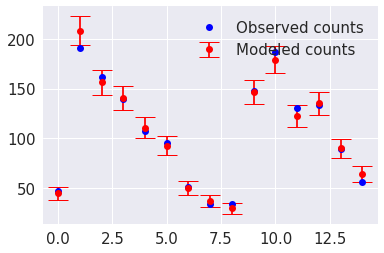

In [14]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend();

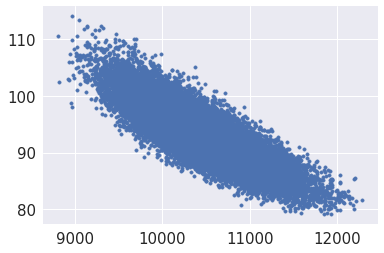

In [15]:
plt.scatter(trace['J0'], trace['E0'], marker='.');

In [16]:
plt.hist(trace['J0'], bins=100, label='trace')
plt.axvline(J0t, c='r', lw=4, label='True value');
plt.legend();

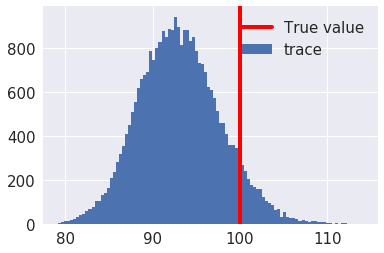

In [17]:
plt.hist(trace['E0'], bins=100, label='trace');
plt.axvline(E0t, c='r', lw=4, label='True value');
plt.legend();

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [18]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

100%|██████████| 2000/2000 [00:04<00:00, 419.16it/s]


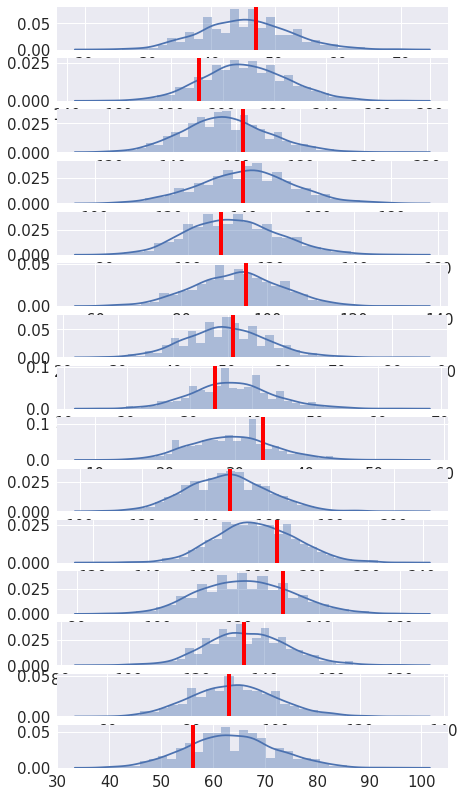

In [19]:
fig, ax = plt.subplots(len(c_obs),1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [20]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
dist = np.zeros((len(E), nS), dtype=float)
for (i, s) in enumerate(random_samples):
    for e in range(len(E)):
        dist[e, i] = spectra(E, trace['J0'][s], trace['E0'][s])[e]

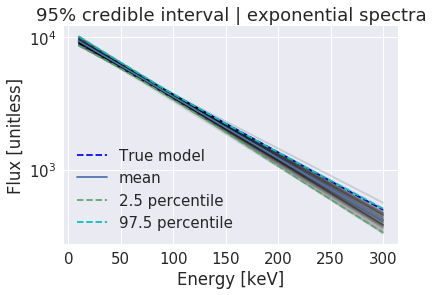

In [21]:
plt.plot(E, spectra(E, J0t, E0t), 'b--', label='True model')
for i in random_samples:
    plt.plot(E, spectra(E, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(dist, axis=1), label='mean');
plt.plot(E, np.percentile(dist, 2.5, axis=1), '--', label='2.5 percentile')
plt.plot(E, np.percentile(dist, 97.5, axis=1), '--', label='97.5 percentile', c='c')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');